<a href="https://colab.research.google.com/github/bakwadunka/dunka1/blob/master/Copy_of_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My\ Drive/sentiment/

/content/drive/My Drive/sentiment


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils.np_utils import to_categorical

In [ ]:
data = pd.read_csv('Sentiments.csv')
data

,tweet_id,timestamp,clean_tweet,Sentiments
0,1184260000000000000,10/15/2019 23:59,(Produced by ) dm for more information on this...,positive
1,1184260000000000000,10/15/2019 23:59,I missed out on trying your black cherry slush...,negative
2,1184260000000000000,10/15/2019 23:59,I hate you,negative
3,1184260000000000000,10/15/2019 23:59,About slam these Tacs and get to work.... I ha...,negative
4,1184260000000000000,10/15/2019 23:59,Yall niggas be knowing yall got a girl but yal...,negative
...,...,...,...,...
10160,1255650000000000000,4/29/2020 23:59,"Yeah, honestly I didnt even mean to imply its ...",negative
10161,1255650000000000000,4/29/2020 23:59,No true Sam imo would ever think Sam would do ...,negative
10162,1255650000000000000,4/29/2020 23:59,i hate when people say you bullshit me mannnn ...,negative
10163,1255650000000000000,4/29/2020 23:59,"The Windrush Immigrants were not illegal, they...",positive


In [ ]:
df = pd.DataFrame()
df['text'] = data['clean_tweet']
df['category'] = data['Sentiments']
df

,text,category
0,(Produced by ) dm for more information on this...,positive
1,I missed out on trying your black cherry slush...,negative
2,I hate you,negative
3,About slam these Tacs and get to work.... I ha...,negative
4,Yall niggas be knowing yall got a girl but yal...,negative
...,...,...
10160,"Yeah, honestly I didnt even mean to imply its ...",negative
10161,No true Sam imo would ever think Sam would do ...,negative
10162,i hate when people say you bullshit me mannnn ...,negative
10163,"The Windrush Immigrants were not illegal, they...",positive


SHAPE OF DATASET:  (10165, 2) 

COLUMNS IN DATASET:  Index(['text', 'category'], dtype='object') 

CATEGORIES:  ['positive' 'negative' 'neutral']
NUMBER OF SAMPLES IN EACH CATEGORY: 



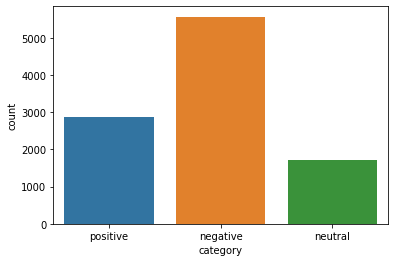

In [ ]:
# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.category.unique())

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(df.category)

In [ ]:
# DATA CLEANING
print('Data cleaning in progress...')
df['text'] = df['text'].apply(str)
# Tokenize
df['text'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text'] = df['text'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



In [ ]:
# Embedding
max_features = 15000
maxlen = 500
embedding_size = 128

tokenizer = Tokenizer(num_words=max_features, split=' ')

tokenizer.fit_on_texts(df['text'].values)

X = tokenizer.texts_to_sequences(df['text'])

X = sequence.pad_sequences(X, maxlen=maxlen)

encoder = LabelBinarizer()
y = encoder.fit_transform(df['category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(8132, 500)
(2033, 500)


In [ ]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 128

# Training
batch_size = 64
epochs = 5

'''
Note:
batch_size is highly sensitive.
You may tune the epochs by changing.
'''

print('Building model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(128,7,padding='valid',activation='relu',strides=1))
model.add(Conv1D(128,7,padding='valid',activation='relu',strides=1))
model.add(MaxPooling1D())
model.add(LSTM(lstm_output_size, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Building model...
Train...
Epoch 1/5
128/128 [==============================] - 246s 2s/step - loss: 0.8716 - accuracy: 0.5722 - val_loss: 0.7822 - val_accuracy: 0.6493
Epoch 2/5
128/128 [==============================] - 248s 2s/step - loss: 0.5842 - accuracy: 0.7607 - val_loss: 0.6450 - val_accuracy: 0.7314
Epoch 3/5
128/128 [==============================] - 246s 2s/step - loss: 0.3474 - accuracy: 0.8688 - val_loss: 0.7130 - val_accuracy: 0.7241
Epoch 4/5
128/128 [==============================] - 245s 2s/step - loss: 0.2288 - accuracy: 0.9147 - val_loss: 0.9040 - val_accuracy: 0.7206
Epoch 5/5
32/32 [==============================] - 11s 347ms/step - loss: 1.0181 - accuracy: 0.7098
Test score: 1.0180859565734863
Test accuracy: 0.7097885012626648


In [ ]:
classes = encoder.classes_
classes

array(['negative', 'neutral', 'positive'], dtype='<U8')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = [classes[x.argmax()] for x in y_pred]
print('predicted:\n',y_pred[:5])
y_test =  [classes[x.argmax()] for x in y_test]
print('actual:\n', y_test[:5])

predicted:
 ['neutral', 'negative', 'negative', 'negative', 'negative']
actual:
 ['neutral', 'negative', 'negative', 'negative', 'neutral']


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
report = classification_report(y_test, y_pred, labels=classes)
cf_matrix = confusion_matrix(y_test, y_pred, labels=my_class)
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.81      0.79      1099
     neutral       0.60      0.61      0.61       366
    positive       0.66      0.58      0.62       568

    accuracy                           0.71      2033
   macro avg       0.68      0.67      0.67      2033
weighted avg       0.71      0.71      0.71      2033



In [ ]:
def show_values(pc, fmt="%.2f", **kw):

    pc.update_scalarmappable()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):

    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):


    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdYlGn', vmin=0.0, vmax=1.0)
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(35, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    #fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):

    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : 6]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

def heatmap_cf(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu', mx = 900):


    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdYlGn', vmin=0.0, vmax=mx)
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(35, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    #fig.set_size_inches(cm2inch(figure_width, figure_height))

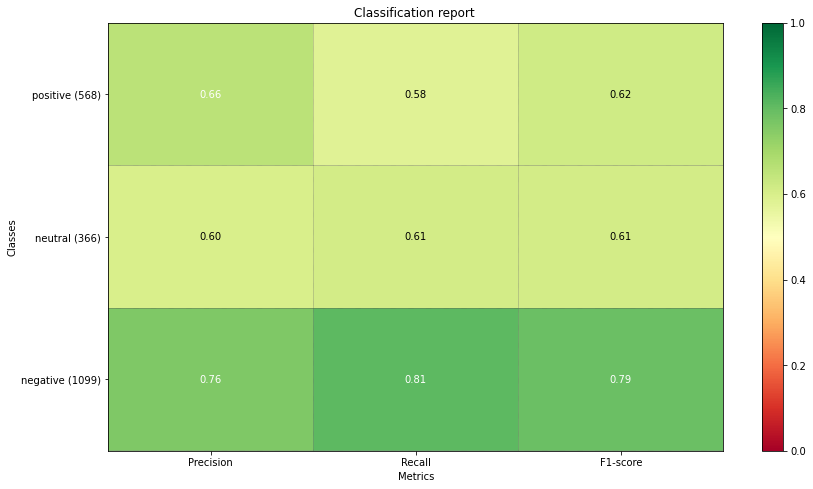

In [ ]:
plot_classification_report(report)

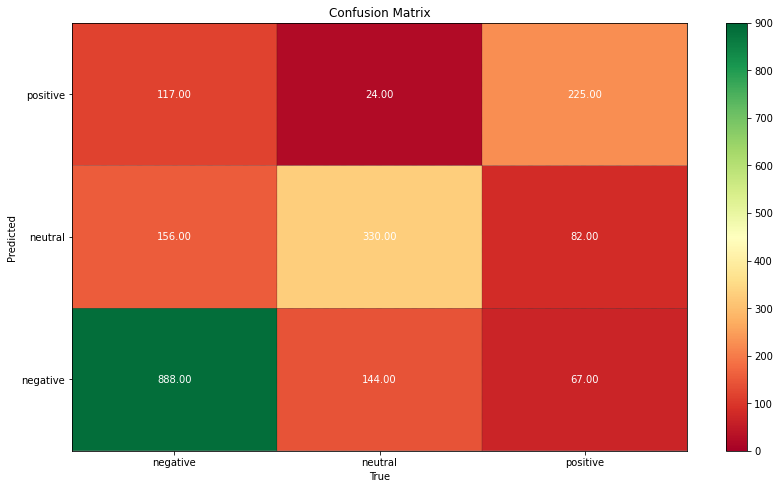

In [ ]:
heatmap_cf(cf_matrix, title='Confusion Matrix' , xlabel="True", ylabel="Predicted", xticklabels=classes, yticklabels=classes)